# Coline FOUCHE 
### Mars 2024
### Test technique - données NeurIPS

#### Packages et chemins

In [1]:
# Packages utilisés dans ce notebook
import os
import pandas as pd

import networkx as nx
from networkx.algorithms.community.centrality import girvan_newman

import matplotlib
import matplotlib.pyplot as plt

import pyvis
from pyvis.network import Network 

In [2]:
# Chemin local
local_path = "C:\\Users\\Coline\\Downloads\\CF_test_technique"
local_data_path = os.path.join(local_path, "0_Data")

#### Import des données

In [3]:
# Données auteurs : 1 ligne = 1 ID auteur
df_authors = pd.read_csv(os.path.join(local_data_path, 'authors.csv'))
print(df_authors.dtypes)
df_authors.head()
# à noter : problème d'encoding sur les caractères allemands dans le fichier (non corrigible au chargement)
# ex : Bernhard Sch?lkopf, Klaus-Robert M?ller

id       int64
name    object
dtype: object


,id,name
0,1,Hisashi Suzuki
1,10,David Brady
2,100,Santosh S. Venkatesh
3,1000,Charles Fefferman
4,10000,Artur Speiser


In [4]:
# Données auteurs x articles : 1 ligne = 1 ID auteur x 1 ID article
df_paper_authors = pd.read_csv(os.path.join(local_data_path, 'paper_authors.csv'))
print(df_paper_authors.dtypes)
df_paper_authors.head()

id           int64
paper_id     int64
author_id    int64
dtype: object


,id,paper_id,author_id
0,1,63,94
1,2,80,124
2,3,80,125
3,4,80,126
4,5,80,127


In [5]:
# Données articles : 1 ligne = 1 ID article
df_papers = pd.read_csv(os.path.join(local_data_path, 'papers.csv'))
print(df_papers.dtypes)
df_papers.head()

id             int64
year           int64
title         object
event_type    object
pdf_name      object
abstract      object
paper_text    object
dtype: object


,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


## Question 1. Analyse des liens entre les auteurs

#### 1.0. Nettoyage et jointure des bases

In [6]:
# Auteurs
print("Nombre de lignes dans la base auteurs :", df_authors.shape[0])
print("Nombre d'identifiants uniques dans la base auteurs :", df_authors['id'].nunique())
print("Nombre de noms uniques dans la base auteurs :", df_authors['name'].nunique())

Nombre de lignes dans la base auteurs : 9784
Nombre d'identifiants uniques dans la base auteurs : 9784
Nombre de noms uniques dans la base auteurs : 9719


In [7]:
print("Nombre de noms d'auteurs apparaissant sous plusieurs identifiants :", 
      df_authors.loc[df_authors['name'].duplicated(keep=False)]['name'].nunique())
df_authors.loc[df_authors['name'].duplicated(keep=False)].sort_values('name')
# 128 lignes dédoublées = 63 auteurs (1 en 3 fois) 
# => les noms étant dans la majorité des cas suffisamment uniques, 
# on fera dans la suite l'hypothèse qu'un même nom représente un même auteur

Nombre de noms d'auteurs apparaissant sous plusieurs identifiants : 63


,id,name
5976,6506,Abhradeep Guha Thakurta
7619,8027,Abhradeep Guha Thakurta
924,1410,Alex J. Smola
6378,6882,Alex J. Smola
1535,1966,Alexander T. Ihler
5349,5418,Alexander T. Ihler
6408,6910,Andrew Y. Ng
1413,1853,Andrew Y. Ng
6391,6894,Angela J. Yu
1866,2266,Angela J. Yu


In [8]:
# Etude de cas sur un exemple d'auteur : Abhradeep Guha Thakurta
print(df_paper_authors.loc[df_paper_authors['author_id'].isin([6506, 8027])])
print(df_papers.loc[df_papers['id'].isin([5012, 5729, 6823]), ['id', 'year', 'title']])
# les articles semblent partager un même thème : il apparait raisonnable de supposer qu'il s'agit bien d'un même auteur

          id  paper_id  author_id
13607  13608      5012       6506
16175  16176      5729       8027
19112  19113      6823       8027
        id  year                                              title
4434  5012  2013  (Nearly) Optimal Algorithms for Private Online...
5223  5729  2015                       Nearly Optimal Private LASSO
6438  6823  2017            Practical Locally Private Heavy Hitters


In [9]:
# Auteurs x articles
print("Nombre de lignes dans la base auteurs x articles :", df_paper_authors.shape[0])
print("Nombre d'identifiants uniques dans la base auteurs x articles :", df_paper_authors['id'].nunique())
print("Nombre d'identifiants auteur uniques dans la base auteurs x articles :", df_paper_authors['author_id'].nunique())
print("Nombre d'identifiants article uniques dans la base auteurs x articles :", df_paper_authors['paper_id'].nunique())

print("Nombre de combinaisons d'identifiants auteur x article uniques dans la base auteurs x articles :", 
      df_paper_authors[['author_id', 'paper_id']].drop_duplicates().shape[0]) 

Nombre de lignes dans la base auteurs x articles : 20838
Nombre d'identifiants uniques dans la base auteurs x articles : 20838
Nombre d'identifiants auteur uniques dans la base auteurs x articles : 9784
Nombre d'identifiants article uniques dans la base auteurs x articles : 7238
Nombre de combinaisons d'identifiants auteur x article uniques dans la base auteurs x articles : 20823


In [10]:
# Vérifications de la présence de duplicats sur la base articles
print("duplicats identifiant")
print(df_papers.loc[df_papers['id'].duplicated(keep=False)])
print("duplicats titre")
print(df_papers.loc[df_papers['title'].duplicated(keep=False)])
print("duplicats titre pdf")
print(df_papers.loc[df_papers['pdf_name'].duplicated(keep=False)])
# aucun duplicat sur le titre, ni id ni pdf_name

duplicats identifiant
Empty DataFrame
Columns: [id, year, title, event_type, pdf_name, abstract, paper_text]
Index: []
duplicats titre
Empty DataFrame
Columns: [id, year, title, event_type, pdf_name, abstract, paper_text]
Index: []
duplicats titre pdf
Empty DataFrame
Columns: [id, year, title, event_type, pdf_name, abstract, paper_text]
Index: []


In [12]:
print("duplicats texte complet")
df_papers.loc[df_papers['paper_text'].duplicated(keep=False)]
# 3 cas de textes identiques 

duplicats texte complet


,id,year,title,event_type,pdf_name,abstract,paper_text
631,1578,1998,Dynamics of Supervised Learning with Restricte...,NaN,1578-dynamics-of-supervised-learning-with-rest...,Abstract Missing,Dynamics of Supervised Learning with\nRestrict...
632,1579,1998,Discovering Hidden Features with Gaussian Proc...,NaN,1579-discovering-hidden-features-with-gaussian...,Abstract Missing,Dynamics of Supervised Learning with\nRestrict...
3862,4497,2012,Emergence of Object-Selective Features in Unsu...,NaN,4497-emergence-of-object-selective-features-in...,Recent work in unsupervised feature learning h...,Emergence of Object-Selective Features in\nUns...
4109,4719,2012,"Burn-in, bias, and the rationality of anchoring",NaN,4719-burn-in-bias-and-the-rationality-of-ancho...,Bayesian inference provides a unifying framewo...,Emergence of Object-Selective Features in\nUns...
5583,6052,2016,Only H is left: Near-tight Episodic PAC RL,Poster,6052-only-h-is-left-near-tight-episodic-pac-rl...,In many applications such as advertisement pla...,Launch and Iterate: Reducing Prediction Churn\...
5584,6053,2016,Launch and Iterate: Reducing Prediction Churn,Poster,6053-launch-and-iterate-reducing-prediction-ch...,Practical applications of machine learning oft...,Launch and Iterate: Reducing Prediction Churn\...
5722,6178,2016,Regret Bounds for Non-decomposable Metrics wit...,Poster,6178-regret-bounds-for-non-decomposable-metric...,We consider the problem of recommending releva...,
6499,6879,2017,Mean Field Residual Networks: On the Edge of C...,Poster,6879-mean-field-residual-networks-on-the-edge-...,We study randomly initialized residual network...,


In [14]:
print("duplicats texte complet")
(df_papers
 .loc[lambda df: df['abstract'] != "Abstract Missing"]
 .loc[lambda df: df['abstract'].duplicated(keep=False)]
)
# 2 cas d'abstracts identiques

duplicats texte complet


,id,year,title,event_type,pdf_name,abstract,paper_text
4585,5149,2013,Online Learning with Costly Features and Labels,Poster,5149-online-learning-with-costly-features-and-...,We study the power of different types of adapt...,Online Learning with Costly Features and Label...
4588,5151,2013,Online Learning with Switching Costs and Other...,Poster,5151-online-learning-with-switching-costs-and-...,We study the power of different types of adapt...,Online Learning with Switching Costs and Other...
5433,5918,2015,Convergence rates of sub-sampled Newton methods,Poster,5918-convergence-rates-of-sub-sampled-newton-m...,"An active learner is given a class of models, ...",Convergence rates of sub-sampled Newton method...
5437,5921,2015,Convergence Rates of Active Learning for Maxim...,Poster,5921-convergence-rates-of-active-learning-for-...,"An active learner is given a class of models, ...",Convergence Rates of Active Learning\nfor Maxi...


In [ ]:
# Devant le faible nombre d'articles dupliqués, on considérera que chaque identifiant article est bien unique

In [15]:
# Jointure
df_q1 = (df_paper_authors
         .rename(columns={'id':'row_id'})
         .merge(df_authors
                .rename(columns={'id':'author_id', 'name':'author_name'}),
                how='left')
        )
df_q1.head()

,row_id,paper_id,author_id,author_name
0,1,63,94,Yaser S. Abu-Mostafa
1,2,80,124,Joshua Alspector
2,3,80,125,Robert B. Allen
3,4,80,126,Victor Hu
4,5,80,127,Srinagesh Satyanarayana


In [16]:
print("Eventuels identifiants auteur non matchés :", df_q1['author_name'].isna().sum())
print("Nombre de noms d'auteurs uniques dans la base :", df_q1['author_name'].nunique())

Eventuels identifiants auteur non matchés : 0
Nombre de noms d'auteurs uniques dans la base : 9719


#### 1.1. Rapide analyse descriptive

In [17]:
# nombre d'auteurs par article - avec 1 auteur = 1 nom unique
print(df_q1.groupby('paper_id')['author_name'].nunique().describe())
# comparaison avec author_id : très légère différence sur la moyenne mais autrement même distribution
print(df_q1.groupby('paper_id')['author_id'].nunique().mean())

count    7238.000000
mean        2.876762
std         1.355956
min         1.000000
25%         2.000000
50%         3.000000
75%         4.000000
max        18.000000
Name: author_name, dtype: float64
2.8768996960486324


In [19]:
# max = 18 auteurs : vérification de l'article
print(df_q1.groupby('paper_id')['author_name'].nunique().sort_values(ascending=False).head())
df_papers.loc[df_papers['id']==2889]
# il y a bien 18 auteurs dans la référence : 
# https://proceedings.neurips.cc/paper_files/paper/2005/hash/7f018eb7b301a66658931cb8a93fd6e8-Abstract.html

paper_id
2889    18
7152    15
6771    13
4687    12
4016    12
Name: author_name, dtype: int64


,id,year,title,event_type,pdf_name,abstract,paper_text
2079,2889,2005,AER Building Blocks for Multi-Layer Multi-Chip...,NaN,2889-aer-building-blocks-for-multi-layer-multi...,Abstract Missing,AER Building Blocks for Multi-Layer Multi-Chip...


In [20]:
# Nombre d'articles par auteur
print(df_q1.groupby('author_name')['paper_id'].nunique().describe())

count    9719.000000
mean        2.142401
std         3.367320
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max       101.000000
Name: paper_id, dtype: float64


In [21]:
# comparaison vs par identifiant auteur
df_q1.groupby('author_id')['paper_id'].nunique().describe()

count    9784.000000
mean        2.128271
std         3.242838
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max        79.000000
Name: paper_id, dtype: float64

In [22]:
# Top des auteurs les plus représentés dans la base
df_q1.groupby('author_name')['paper_id'].nunique().sort_values(ascending=False).head()

author_name
Michael I. Jordan     101
Bernhard Sch?lkopf     62
Yoshua Bengio          60
Geoffrey E. Hinton     58
Zoubin Ghahramani      51
Name: paper_id, dtype: int64

#### 1.2 Préparation des données

In [24]:
# format 1 ligne = 1 association auteur 1 - auteur 2

df_q1_graph = (df_q1
               # jointure sur l'id article pour créer une 2e colonne auteur 2
               .merge(df_q1[['author_name', 'paper_id']], on='paper_id', how='inner')
               .rename(columns={'author_name_x':'author_1', 'author_name_y':'author_2'})
               # suppression des lignes pour lesquelles auteur 1 = auteur 2 (pas de lien à comptabiliser)
               .loc[lambda df: df['author_1'] != df['author_2']]
               .reset_index(drop=True)
               # suppression des paires symétriques (ie Y-X vs X-Y), par ordre alphabétique
               .loc[lambda df: df['author_1'] < df['author_2']]
               .reset_index(drop=True)
              )

# assignation d'un poids à chaque paire = nombre d'articles co-publiés
df_q1_graph = (df_q1_graph
               .groupby(['author_1', 'author_2'])['paper_id'].nunique()
               .sort_values(ascending=False)
               .reset_index()
               .rename(columns={'paper_id':'weight'})
              )

df_q1_graph.head()

,author_1,author_2,weight
0,Inderjit S. Dhillon,Pradeep K. Ravikumar,18
1,Alex J. Smola,Bernhard Sch?lkopf,12
2,Ralf Herbrich,Thore Graepel,11
3,Corinna Cortes,Mehryar Mohri,11
4,Martin J. Wainwright,Michael I. Jordan,11


In [25]:
df_q1_graph['weight'].describe()
# environ 22k lignes, en majorité des poids = 1

count    22145.000000
mean         1.182750
std          0.619609
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         18.000000
Name: weight, dtype: float64

In [29]:
print("Nombre de paires apparaissant plus d'une fois :", len(df_q1_graph.loc[lambda df: df['weight']>1])) 
print("Nombre de paires apparaissant plus de deux fois :", len(df_q1_graph.loc[lambda df: df['weight']>2])) 
print("Nombre de paires apparaissant plus de trois fois :", len(df_q1_graph.loc[lambda df: df['weight']>3])) 

Nombre de paires apparaissant plus d'une fois : 2697
Nombre de paires apparaissant plus de deux fois : 776
Nombre de paires apparaissant plus de trois fois : 291


#### 1.3. Création et visualisation d'un graphe

In [35]:
# Création du graphe sur les paires apparaissant 4 fois ou plus pour faciliter le traitement
G_small = nx.from_pandas_edgelist(df=df_q1_graph.loc[lambda df: df['weight']>3], 
                                  source='author_1', 
                                  target='author_2', 
                                  edge_attr='weight')

# Note : il sera intéressant d'étudier l'impact du paramètre filtrant sur la création des communautés en partie 1.4

In [36]:
# Création d'une palette de couleurs
max_n = 10 # max nombre de voisins
cmap_neighbors = plt.cm.get_cmap('rainbow', max_n) 

In [37]:
# Visualisation du graphe et mise en évidence des auteurs comptant le plus de liens

net = Network(notebook=True)
net.show_buttons(filter_=["physics"])

for node in G_small.nodes:
    # assignation d'une couleur sur le noeud selon le nombre de voisins
    n_neighbors = len(list(nx.all_neighbors(G_small, node)))
    n_color = matplotlib.colors.rgb2hex(cmap_neighbors(n_neighbors), keep_alpha=True)
    net.add_node(node, color=n_color)
net.add_edges(G_small.edges)
net.show('graphe_auteurs_nips.html')

graphe_auteurs_nips.html


In [38]:
# liste des auteurs comptant le plus de voisins (avec 4 articles partagés ou plus)
top_auteurs_voisins = pd.DataFrame.from_dict({node: len(list(nx.all_neighbors(G_small, node))) for node in G_small.nodes}, 
                                             orient='index').reset_index()
top_auteurs_voisins.columns = ['author_name', 'no_voisins']
top_auteurs_voisins = top_auteurs_voisins.sort_values(by='no_voisins', ascending=False).head(10)
top_auteurs_voisins

,author_name,no_voisins
12,Lawrence Carin,10
2,Alex J. Smola,9
9,Michael I. Jordan,8
3,Bernhard Sch?lkopf,8
0,Inderjit S. Dhillon,7
74,Terrence J. Sejnowski,7
25,Klaus-Robert M?ller,6
15,Arthur Gretton,6
8,Martin J. Wainwright,6
21,Yoshua Bengio,6


#### 1.4. Détection de communautés

In [ ]:
# Références utilisées : 
# https://networkx.org/documentation/stable/auto_examples/algorithms/plot_girvan_newman.html
# https://memgraph.com/blog/community-detection-algorithms-with-python-networkx

In [42]:
# Création des communautés avec l'algorithme de Girvan-Newman

communities = girvan_newman(G_small)
# note : d'autres algorithmes seraient à tester mais nécessitent davantage de retraitements sur le format des noeuds (id + label)
# exemple : Louvain, label propagation, k cliques

# Mise au format liste des dictionnaires obtenus
node_groups = []
for com in next(communities):
  node_groups.append(list(com))

communities_list = list(communities)

print(len(node_groups), "communautés détectées")

107 communautés détectées


In [43]:
# Visualisation

net = Network(notebook=True)
net.show_buttons(filter_=["physics"])

# exemple pour 4 communautés

for node in G_small.nodes:
    # assignation d'une couleur sur le noeud selon la communauté
    if node in node_groups[0]:
        c_color = 'red'
    elif node in node_groups[1]: 
        c_color = 'orange' 
    elif node in node_groups[2]:
        c_color = 'yellow'
    else:
        c_color = 'purple'
    net.add_node(node, color=c_color)
net.add_edges(G_small.edges)
net.show('graphe_auteurs_nips_communautes.html')

graphe_auteurs_nips_communautes.html


C:\Users\Coline\Anaconda3.1\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


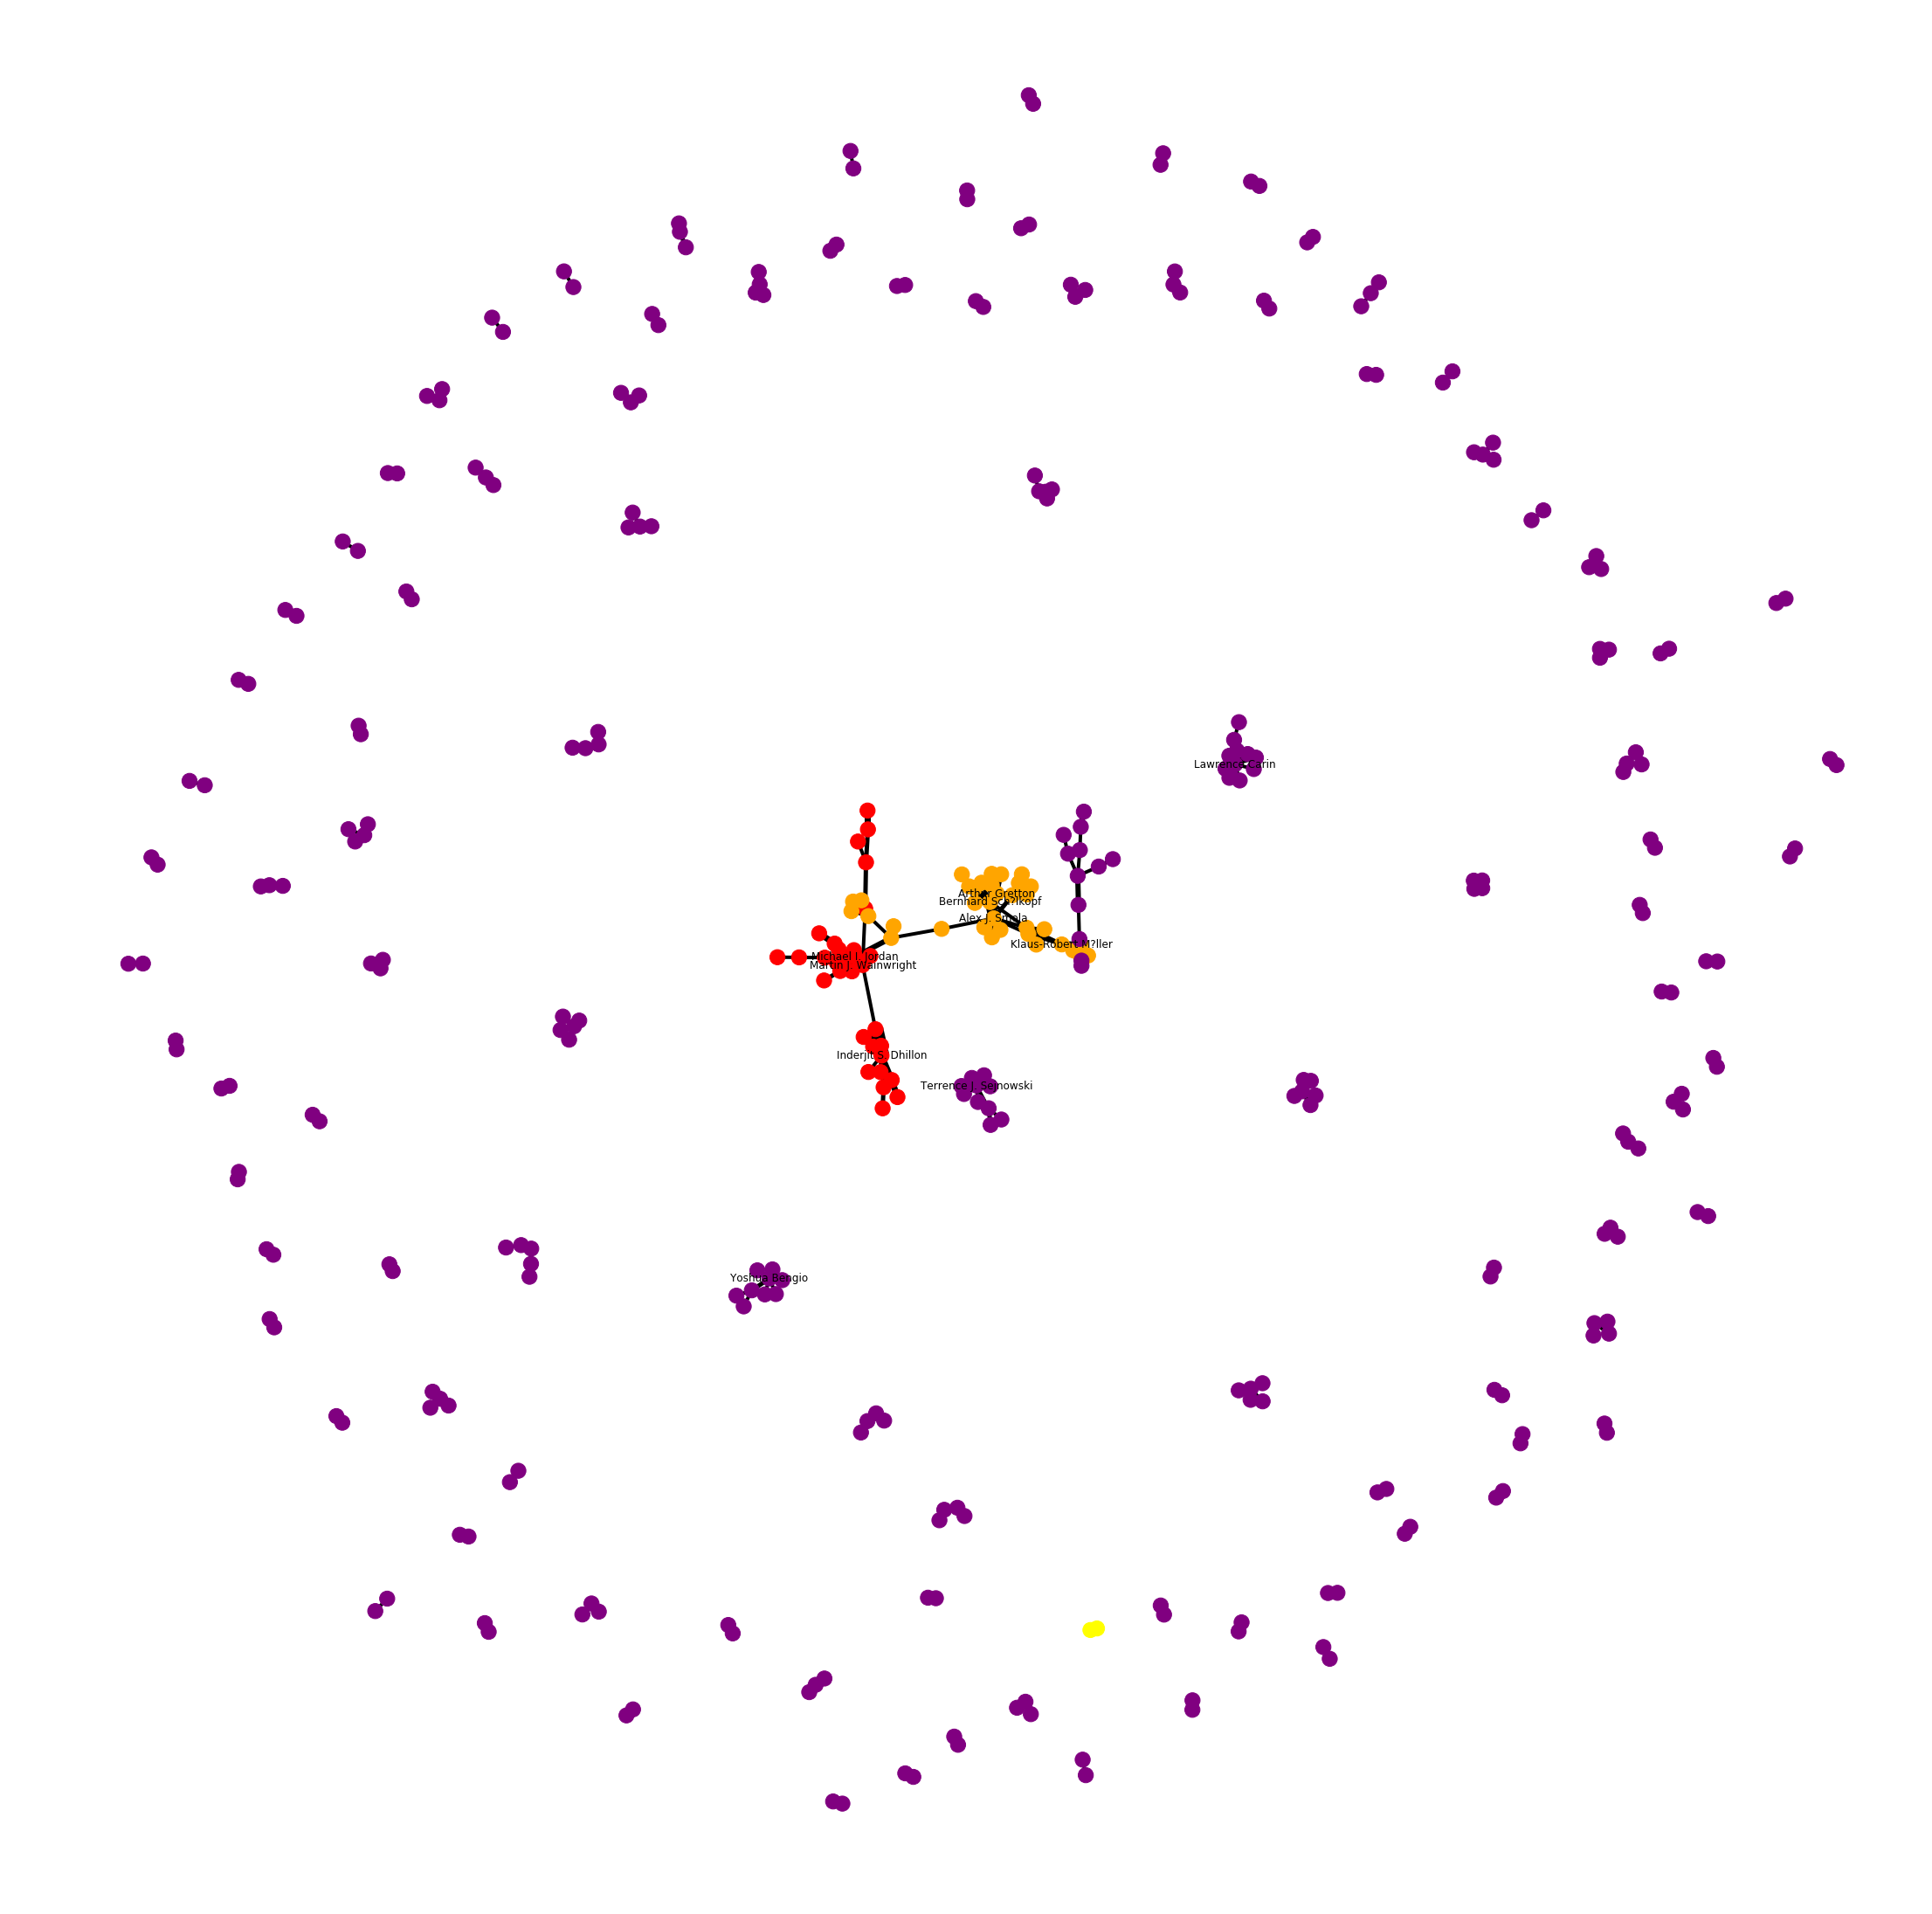

In [44]:
### version matplotlib
fig = plt.figure(figsize=(30, 30))

# exemple pour 4 communautés
color_map = []
for node in G_small:
    if node in node_groups[0]:
        color_map.append('red')
    elif node in node_groups[1]: 
        color_map.append('orange') 
    elif node in node_groups[2]:
        color_map.append('yellow')
    else:
        color_map.append('purple')
           
# labelliser les auteurs comptant le plus de voisins
labels = {
    node: (node if node in top_auteurs_voisins['author_name'].unique()
        else '')
    for node in G_small.nodes
}        

nx.draw(G_small, 
        width=list(nx.get_edge_attributes(G_small, 'weight').values())*10, 
        node_color=color_map, 
        with_labels=True, 
        labels=labels)

plt.savefig(os.path.join(local_path, '2_Results', 'graph_communities.png'), dpi=1000)

plt.show()

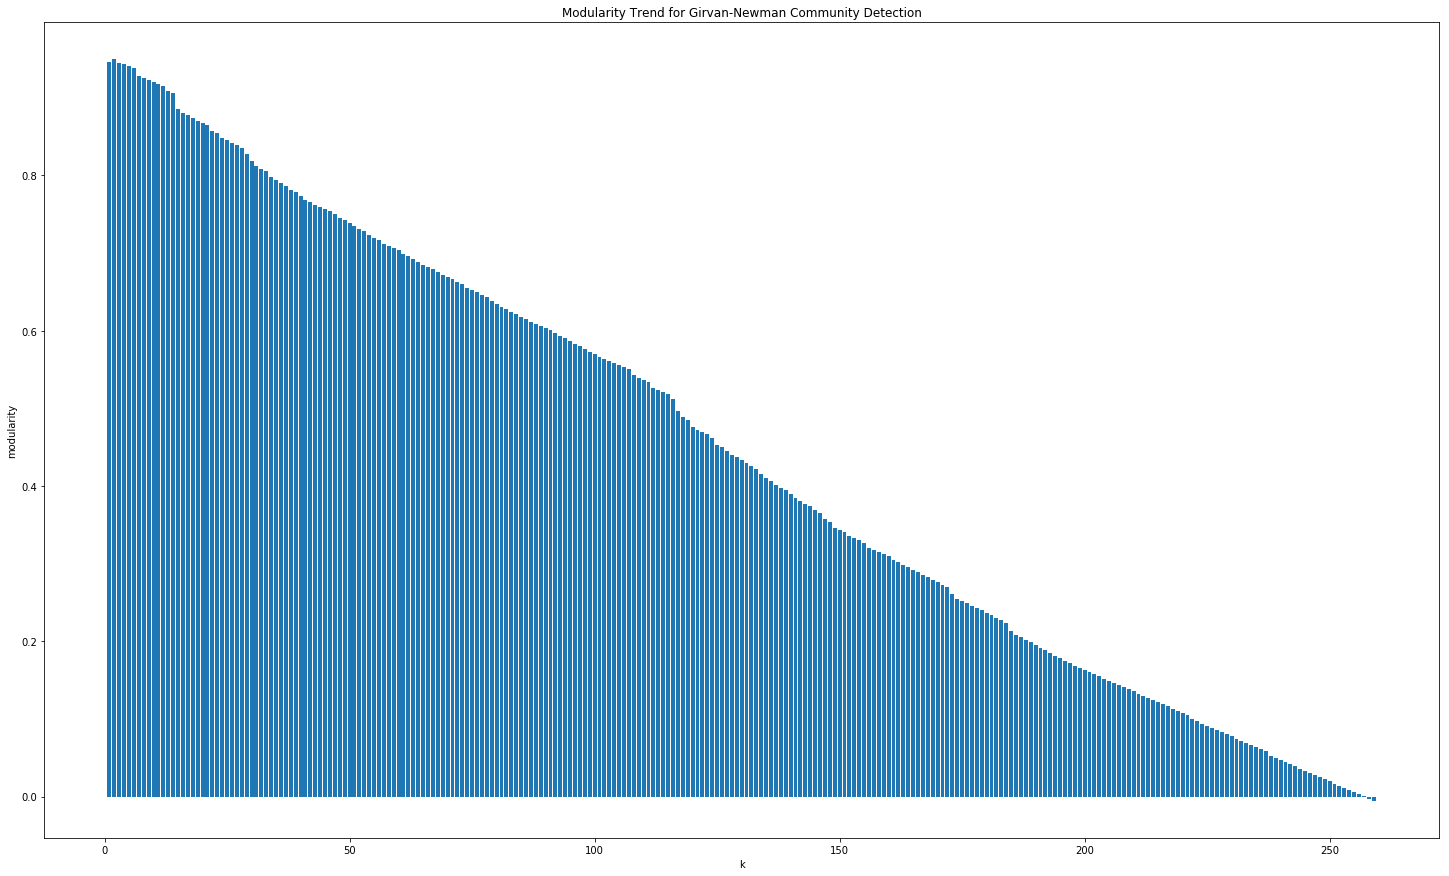

In [45]:
# Evolution de la modularité à mesure que l'on retire les arêtes importantes 

# Modularité -> mesure de la force de division d'un graphe
modularity_df = pd.DataFrame(
    [[k + 1, nx.community.modularity(G_small, communities_list[k])]
        for k in range(len(communities_list))],
    columns=["k", "modularity"],
)

fig = plt.figure(figsize=(25, 15))

plt.bar(data=modularity_df,
        x="k",
        height="modularity")
plt.title("Modularity Trend for Girvan-Newman Community Detection")
plt.xlabel('k')
plt.ylabel('modularity')

plt.savefig(os.path.join(local_path, '2_Results', 'graph_modularity.png'), dpi=1000)

plt.show()
# la modularité apparait maximisée à k=2 communautés

# Question 2. Autres visualisations du dataset

Propositions : 
- clustering des articles
- clustering des auteurs
- détection de thèmes dans le corpus (nuage de mots, LDA...)